# EffNetB0 model trained twice, once for each of two training populations

As described in @pcjimmmy's [notebook][2], the sum of total votes for each label_id indicates the training data may have been collected from two sources. One population has 1-7 total votes, and the other 10-28 votes. Each population also displays unique class imbalance.

Regardless of the data's source, the two populations exist within the training data. I began to think about the implication of training with data that has few votes. Consider the extreme of only one vote cast. Training on this data would likely result in a model that predicts a class with high probability, while the remaining probabilites are nearly zero. If a pobablility is predicted to be nearly zero, but the true probability is much higher, KL-divergence will be very high due to the division by nearly zero in the logarithm (P(x)log(P(x)/Q(x)). (As evidence of this, I modified my [EfficientNetB0 Noisy Student notebook][0] by replacing the least probable class prediction with 1e-5 and submitting, resulting in worse performance: LB 0.42 -> 0.49).

Reasoning how samples with peaked distributions may not be the best for training, I considered only using samples with 10-28 total votes. However, the reduction to the dataset is too extreme. Then, I had the insight to train in 2 stages: first with the 1-7 vote population, then the 10-28 vote population. I thought the first training stage could learn from the peaked distributions (and the seizure samples), then the second stage of training could adjust to have less peaked distributions, addressing the KL-divergence issue. 

Spliting the data reduces the amount of training data for each training stage, so I sought to increase the number of samples used. I reduced the size of the `train.csv` to 20,183 rows by dropping duplicates of [`eeg_id`, `seizure_vote`, `lpd_vote`, `gpd_vote`, `lrda_vote`,`grda_vote`, `other_vote`]. That's 3,094 more samples than @cdeotte's [original notebook][1], which uses only unique `eeg_ids`.

In that notebook, he also used EEG spectrograms he [created][6] for each eeg_id, using data from the central 50 seconds of the EEG. [My approach][4] is to create a unique spectrogram for each label_id, using `eeg_label_offset_seconds` instead of the centered 50-second sample. The result is more training data with slight variations.

Training with this data in two stages results in CV 0.68 and LB 0.39.

___
Thank you to @cdeotte! This notebook is heavily influenced by his [notebook][1].

Thank you to @pcjimmmy! His [notebook][2] and insight into the two dataset sources inspired this notebook.

If you find the EEG spectrograms useful, please upvote my [dataset][3] and associated [notebook][4]

Note: this EfficientNet model initializes with [noisy student weights][5]

[0]: https://www.kaggle.com/code/seanbearden/efficientnetb0-noisy-student-lb-0-42
[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43
[2]: https://www.kaggle.com/code/pcjimmmy/patient-variation-eda
[3]: https://www.kaggle.com/datasets/seanbearden/eeg-spectrogram-by-lead-id-unique
[4]: https://www.kaggle.com/code/seanbearden/spectrogram-from-unique-eeg-votes-combo
[5]: https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights
[6]: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg

# Update: Testing the addition of TUSZ seizure data

I've processed [The Temple University Hospital Seizure Detection Corpus][1] for use in this competition, which can be found [here][2]. I'm testing out how the data affects model performance. 

~~Since the data only affects the second stage of training, the stage 1 weights from v1 are used to initialize stage 2.~~

Accidentally retrained with pop2 weights on second stage. Submitting to see LB.

[1]: https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml
[2]: https://www.kaggle.com/datasets/seanbearden/hms-hba-tuh-tusz-seizures


| Details | 1st CV | 2nd CV | Final CV | EffNet LB | Notebook version | Model | Loss | Epochs | Data Augmention |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Split Uniq Votes | 0.81 | 0.29 | 0.68 | 0.39 | 1-6 | EffNetB0 | KL-Div | 5 | none |
| TUSZ Seizures in Stage 2 (retrain) | ??? | ??? | ??? | ??? | 7-8 | EffNetB0 | KL-Div | 5 | none |

# Initialize 2xT4 GPUs
We will use both Kaggle T4 GPUs and we will use mixed precision.

In [1]:
import os #, gc
import time
import json
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold
import tensorflow.keras.backend as K, gc
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt


print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version = 2.13.0
Using 2 GPUs


In [2]:
# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS

LOAD_MODELS_FROM_1 = '/kaggle/input/effnetb0-2-pop-model-train-twice-v1'
LOAD_MODELS_FROM_1_NAME = 'EffNet_pop2_v1'

LOAD_MODELS_FROM_2 = '/kaggle/input/effnetb0-2-pop-model-train-twice-v1' 

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True
# USE MIXED PRECISION
MIXED_PRECISION = True
# READ ALL SPECTROGRAMS
READ_SPEC_FILES = False
# # READ ALL EEG SPECTROGRAMS
READ_EEG_SPEC_FILES = False

EVAL_ONLY = True

In [3]:
from pathlib import Path

VERSION = 1

MODEL_NAME = f'effnetB0_2_pop_twice_train_v{VERSION}'
MODEL_LOC = f'models/{MODEL_NAME}'

NOTES = """Split training data into 2 populations based on total vote sum.
EffNetB0 efficientnet package with unique eeg_id and votes.
Using GKF and no augmentation.
Adding TUSZ seizures to pop 2 dataset. Used previous weights in stage 2 and retrained
"""

SEED = 2444
BATCH_SIZE = 32
FOLDS = 5 # 5-fold cross-validation.


LR_START = 1e-4
LR_MAX = 1e-4
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 2
LR_STEP_DECAY = 0.5 # 0.5
LR_EVERY = 1
EPOCHS = 5
PATIENCE = 2
START_FROM_EPOCH = 2

TIMESTAMP = pd.Timestamp.now('utc')

model_info = {
    'api': f'TensorFlow version = {tf.__version__}',
    'datetime': TIMESTAMP.isoformat(),
    'filename': 'efficientnet_tf_unique_vote.ipynb',
    'folds': FOLDS,
    'model': MODEL_NAME,
    'notes': NOTES,
    'path': MODEL_LOC,
    'version': VERSION,
    'SEED': SEED,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'FOLDS': FOLDS,
    'PATIENCE': PATIENCE,
    'USE_KAGGLE_SPECTROGRAMS': USE_KAGGLE_SPECTROGRAMS,
    'USE_EEG_SPECTROGRAMS': USE_EEG_SPECTROGRAMS,
    'MIXED_PRECISION': MIXED_PRECISION,
    'READ_SPEC_FILES': READ_SPEC_FILES,
    'READ_EEG_SPEC_FILES': READ_EEG_SPEC_FILES,
    'LR_START': LR_START,
    'LR_MAX': LR_MAX,
    'LR_RAMPUP_EPOCHS': LR_RAMPUP_EPOCHS,
    'LR_SUSTAIN_EPOCHS': LR_SUSTAIN_EPOCHS,
    'LR_STEP_DECAY': LR_STEP_DECAY,
    'LR_EVERY': LR_EVERY,
    'START_FROM_EPOCH': START_FROM_EPOCH,
     }

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)

# Check if the directory exists
if not os.path.exists(MODEL_LOC):
    Path(MODEL_LOC).mkdir(parents=True, exist_ok=True)
    
model_info_path = os.path.join(MODEL_LOC, 'model_info.json')
with open(model_info_path, 'w') as f:
    json.dump(model_info, f)

In [4]:
# USE MIXED PRECISION
if MIXED_PRECISION:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


# Load Train Data

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.
There are 20183 unique eeg_id + votes in the training data.


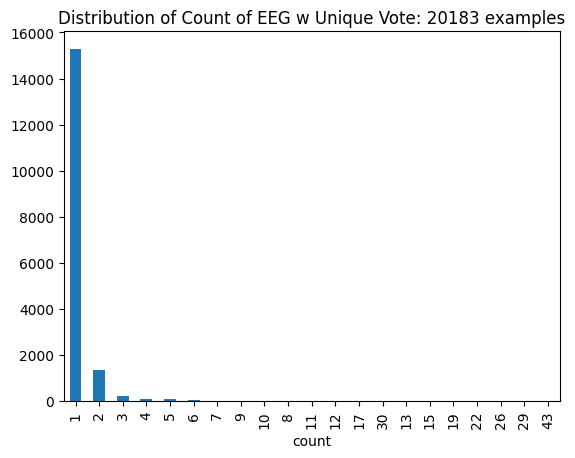

In [5]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))

df['total_evaluators'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

df_uniq = df.drop_duplicates(subset=['eeg_id'] + list(TARGETS))
# df_uniq = df_uniq.sort_values('eeg_id', ascending=True)
print(f'There are {df.patient_id.nunique()} patients in the training data.')
print(f'There are {df.eeg_id.nunique()} EEG IDs in the training data.')
print(f'There are {df_uniq.shape[0]} unique eeg_id + votes in the training data.')

df_uniq.eeg_id.value_counts().value_counts().plot(kind='bar', title=f'Distribution of Count of EEG w Unique Vote: '
                                                                    f'{df_uniq.shape[0]} examples');

~90% of eeg_ids have 1 unique distribution of votes.

As @pcjimmmy has shown in his [notebook](https://www.kaggle.com/code/pcjimmmy/patient-variation-eda), the data breaks into two populations when considering the total number of votes per label_id. 

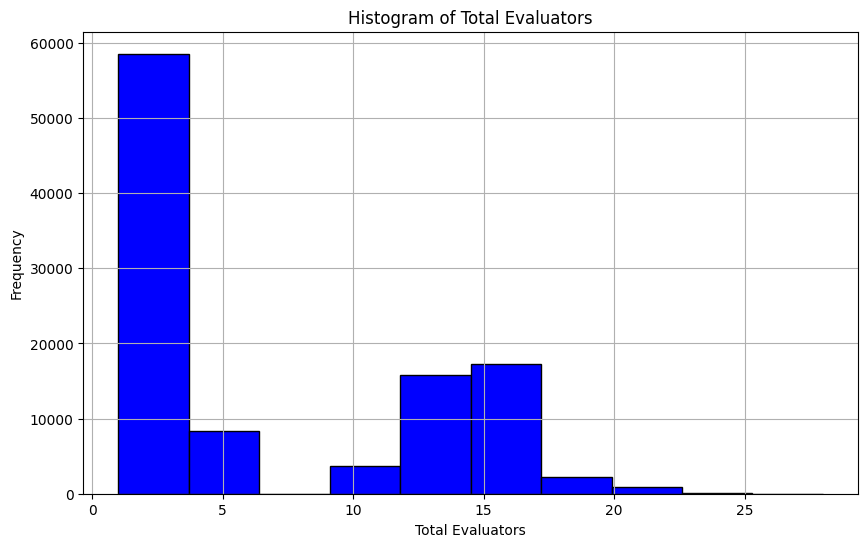

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Read Train Spectrograms 

First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Thank you for upvoting my helpful [dataset][1] :-)

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

In [7]:
%%time
if not EVAL_ONLY:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


# Read EEG Spectrograms

These EEG [spectrograms][1] are a modification of @cdeotte's [spectrograms][4]. The dictionary keys are label_ids for unique eeg_id + vote combo.

[1]: https://www.kaggle.com/datasets/seanbearden/eeg-spectrogram-by-lead-id-unique
[2]: https://www.kaggle.com/code/seanbearden/spectrogram-from-unique-eeg-votes-combo
[3]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms
[4]: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg

In [8]:
%%time
if not EVAL_ONLY:
    all_eegs = np.load('/kaggle/input/eeg-spectrogram-by-lead-id-unique/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


# TUSZ Seizure Data

In [9]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False, offset=None):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
#     print(eeg.shape)
    if offset is None:
        middle = (len(eeg)-10_000)//2
        eeg = eeg.iloc[middle:middle+10_000]
    else:
        eeg = eeg.iloc[offset:offset+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1: 
                x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
#             plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
#         plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [10]:
# if not EVAL_ONLY:
df_tusz = pd.read_csv('/kaggle/input/hms-hba-tuh-tusz-seizures/seizures.csv')
df_tusz.head()

,id,path,reference_type,group,patient_id,session,start_time,stop_time,class_code,directory,event_time,EKG,processed,missing_data
0,00006107_s001_t001_1,/kaggle/input/the-tuh-eeg-seizure-corpus-tusz-...,03_tcp_ar_a,61,6107,s001_2009_09_22,300.7539,349.7555,gnsz,train,49.0016,True,True,0.000000
1,00006107_s001_t001_3,/kaggle/input/the-tuh-eeg-seizure-corpus-tusz-...,03_tcp_ar_a,61,6107,s001_2009_09_22,496.5664,547.5938,gnsz,train,51.0274,True,True,0.276803
2,00006107_s001_t002_1,/kaggle/input/the-tuh-eeg-seizure-corpus-tusz-...,03_tcp_ar_a,61,6107,s001_2009_09_22,1.0000,30.1831,gnsz,train,29.1831,True,True,0.001790
3,00006107_s001_t002_3,/kaggle/input/the-tuh-eeg-seizure-corpus-tusz-...,03_tcp_ar_a,61,6107,s001_2009_09_22,315.0859,358.6172,gnsz,train,43.5313,True,True,0.000000
4,00006107_s001_t003_1,/kaggle/input/the-tuh-eeg-seizure-corpus-tusz-...,03_tcp_ar_a,61,6107,s001_2009_09_22,300.3047,336.2539,gnsz,train,35.9492,True,True,0.000000


In [11]:
if not EVAL_ONLY:
    df_seiz = df_tusz[~df_tusz.class_code.isin(['bckg', 'atsz', 'mysz']) & df_tusz['processed']]
    df_seiz.class_code.value_counts()
    df_seiz.groupby('session')['event_time'].max()
    df_sorted = df_seiz.sort_values(by=['patient_id', 'session', 'class_code', 'event_time'], ascending=[True, True, True, False])

    # Drop duplicates keeping the first occurrence (which has the longest duration due to sorting)
    df_unique_sessions = df_sorted.drop_duplicates(subset=['patient_id', 'session', 'class_code'], keep='first')

    
    df_tusz_mod = df_unique_sessions[['id', 'patient_id', 'session', 'class_code']].copy()
    df_tusz_mod.loc[:, 'eeg_id'] = df_tusz_mod['patient_id'].astype(str) + df_tusz_mod['session']
    df_tusz_mod.loc[:, 'eeg_sub_id'] = df_unique_sessions['id']
    df_tusz_mod.loc[:, 'eeg_label_offset_seconds'] = 0.0
    df_tusz_mod.loc[:, 'spectrogram_id'] = df_unique_sessions['id']
    df_tusz_mod.loc[:, 'spectrogram_sub_id'] = df_unique_sessions['id']
    df_tusz_mod.loc[:, 'spectrogram_label_offset_seconds'] = 0.0
    df_tusz_mod.loc[:, 'label_id'] = df_unique_sessions['id']
    df_tusz_mod.loc[:, 'patient_id'] += df.patient_id.max() # prevent duplicate patient ids
    df_tusz_mod.loc[:, 'expert_consensus'] = 'Seizure'
    df_tusz_mod.loc[:, ['seizure_vote', 'lpd_vote','gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']] = 0
    df_tusz_mod.loc[:, 'seizure_vote'] = 10 # all are seizures, want to be in pop 2
    df_tusz_mod.drop(['id', 'session', 'class_code'], axis=1, inplace=True)
    df_tusz_mod = df_tusz_mod.loc[:, ['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
           'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
           'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
           'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]

In [12]:
if not EVAL_ONLY:
    tusz_specs = {}
    tusz_eegs = {}
    for file_id in df_unique_sessions['id']:
        # this is raw EEG signal...neeed
        tusz_specs[file_id] = pd.read_parquet(f'/kaggle/input/hms-hba-tuh-tusz-seizures/eeg_10min_spec/{file_id}.parquet').iloc[:, 1:].values
#         tusz_eegs[file_id] = pd.read_parquet()
        tusz_eegs[file_id] = spectrogram_from_eeg(f'/kaggle/input/hms-hba-tuh-tusz-seizures/eeg_raw/{file_id}.parquet', display=False, offset=0)

In [13]:
if not EVAL_ONLY:
    df = pd.concat([df, df_tusz_mod], ignore_index=True)

    spectrograms = spectrograms | tusz_specs
    all_eegs = all_eegs | tusz_eegs

# Training DataFrame

In [14]:
if not EVAL_ONLY:
    train = df[df['label_id'].isin(all_eegs.keys())].copy()
    
    pop_1_idx = train['total_evaluators'] < 10
    
    y_data = train[TARGETS].values
    y_data = y_data / y_data.sum(axis=1,keepdims=True)
    train[TARGETS] = y_data

    train['target'] = train['expert_consensus']
    
    train_pop_1 = train[pop_1_idx].copy().reset_index()
    train_pop_2 = train[~pop_1_idx].copy().reset_index()
    # train = train.reset_index()
    print('Pop 1: train unique eeg_id + votes shape:', train_pop_1.shape )
    plt.figure(figsize=(10, 6))
    plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
    plt.title('Histogram of Total Evaluators')
    plt.xlabel('Total Evaluators')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Train DataLoader
This dataloader outputs 4 spectrogram images as a 4 channel image of size 128x256x4 per train sample. This notebook version is not using data augmention but the code is available below to experiment with albumentations data augmention. Just add `augment = True` when creating the train data loader. And consider adding new transformations to the augment function below.

In [15]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}
 # 256
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, specs, eeg_specs,
                 batch_size=32, shuffle=False, augment=False, mode='train'): 
        self.dim_1 = 256
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X) 
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),128,self.dim_1,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,self.dim_1),dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test': 
                r = 0
                spec_id = row.spec_id
            elif self.mode in ['ensemble', 'granular_train', 'granular_valid']:
                r = int(row['spectrogram_label_offset_seconds'] // 2)
                spec_id = row['spectrogram_id']
            else: 
                r = int( (row['min'] + row['max'])//4 )
                spec_id = row.spec_id

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22] / 2.0
            
            if self.mode in ['ensemble', 'granular_train', 'granular_valid']:
                # ensemble uses label_id as a unique identifier
                img = self.eeg_specs[row.label_id]
            else:
                # EEG SPECTROGRAMS
                img = self.eeg_specs[row.eeg_id]
            X[j,:,:,4:] = img

            if self.mode!='test':
                y[j,] = row[TARGETS]
            
        return X,y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

# Train Scheduler

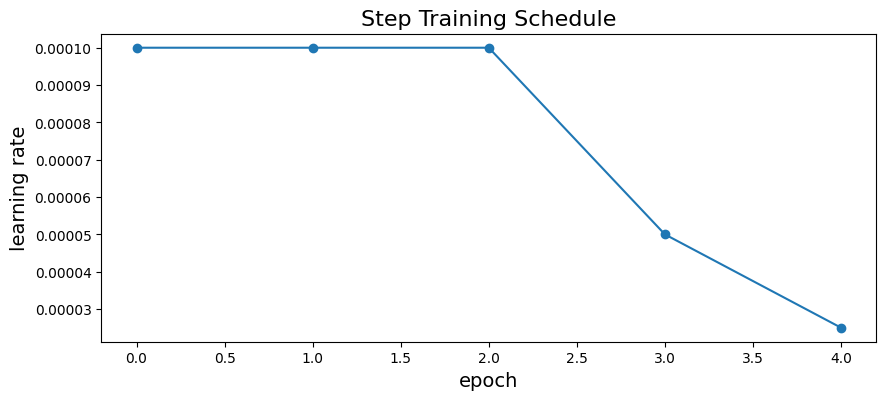

In [16]:
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//LR_EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

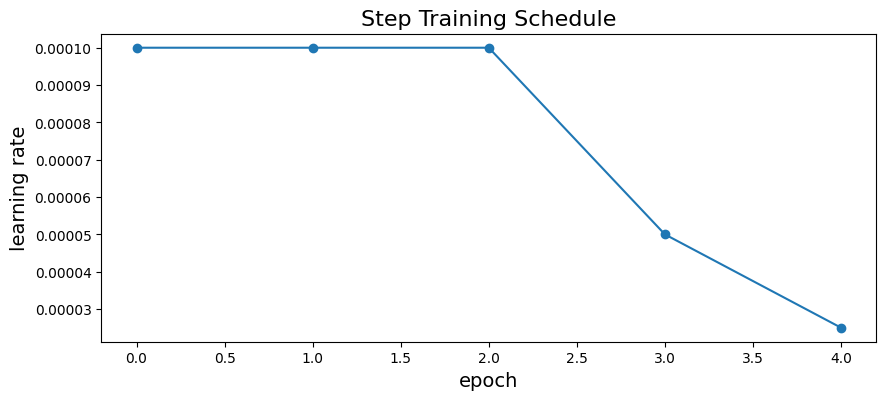

In [17]:
def lrfn2(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//LR_EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn2(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose = True)

## Build EfficientNet Model

In [18]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [19]:
import efficientnet.tfkeras as efn


def build_model():
    
    inp = tf.keras.Input(shape=(128,300,10))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:,:,:,i:i+1] for i in range(4)] #300
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    elif USE_EEG_SPECTROGRAMS: 
        x = x2
    else: 
        x = x1
    # possible to change input channel?
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])

    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#   x = tf.keras.layers.Dense(1024, activation='relu')(x)
#   x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)

    # Add your custom layers
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
#     opt = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt) 
        
    return model

# Train Model
We train using Group KFold on patient id. If `LOAD_MODELS_FROM = None`, then we will train new models in this notebook version. Otherwise we will load saved models from the path `LOAD_MODELS_FROM`.

In [20]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
if not EVAL_ONLY:
    import sys
    sys.path.append('/kaggle/input/kaggle-kl-div')
    from kaggle_kl_div import score

    EARLY_STOP = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        restore_best_weights=True,
        patience=PATIENCE,
        start_from_epoch=START_FROM_EPOCH,
        min_delta=0.0025
    )

    all_oof = []
    all_true = []
    all_histories = []
 
    gkf = GroupKFold(n_splits=FOLDS)
    val_indices = {}
    val_label_ids = {}
    preds={}
    for fold_idx, (train_index, valid_index) in enumerate(gkf.split(train_pop_1, train_pop_1.target, train_pop_1.patient_id)):  
        val_indices[fold_idx] = [str(i) for i in valid_index]
        print('#'*25)
        print(f'### Fold {fold_idx+1}')
        train_valid = train_pop_1.iloc[valid_index]
        val_label_ids[fold_idx] = [str(i) for i in train_valid['label_id']]

        train_gen = DataGenerator(train_pop_1.iloc[train_index], specs=spectrograms, eeg_specs=all_eegs,
                                  shuffle=True, batch_size=BATCH_SIZE, augment=False, mode='granular_train')
        valid_gen = DataGenerator(train_valid, specs=spectrograms, eeg_specs=all_eegs,
                                  shuffle=False, batch_size=64, mode='granular_valid')

        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)

        K.clear_session()
        with strategy.scope():
            model = build_model()
        h5_filename = f'EffNet_pop1_v{VERSION}_f{fold_idx}.h5'
        if LOAD_MODELS_FROM_1 is None:
            
            # ModelCheckpoint callback to save the best model
            h5_path = os.path.join(MODEL_LOC, h5_filename)
            CHECKPOINT = tf.keras.callbacks.ModelCheckpoint(
                h5_path,         # Path where to save the model
                save_best_only=True,     # Only save a model if `val_loss` has improved
                monitor='val_loss',      # Monitor 'val_loss' for improvement
                mode='min'               # The smaller the `val_loss`, the better
            )


            history = model.fit(train_gen, verbose=1,
                  validation_data = valid_gen,
                  epochs=EPOCHS, callbacks = [EARLY_STOP, LR, CHECKPOINT, 
#                                               CM, TENSORBOARD_CALLBACK
                                             ])
            all_histories.append(history)
            model.load_weights(h5_path)

        else:            
            # load weights from pop 2 training to get oof 
            h5_filename = f'{LOAD_MODELS_FROM_1_NAME}_f{fold_idx}.h5'
            model.load_weights(os.path.join(LOAD_MODELS_FROM_1, h5_filename))

        oof = model.predict(valid_gen, verbose=1)
        all_oof.append(oof)
        all_true.append(train_valid[TARGETS].values)

        preds[fold_idx] = oof

        del model, oof
        gc.collect()


    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)


    if LOAD_MODELS_FROM_1 is None:
        history_dict = {}
        for fold, h in enumerate(all_histories):
            history_dict[fold] = str(h.history)

        with open('histories.json', 'w') as file:
            json.dump(history_dict, file, indent=4)

        with open('val_indices.json', 'w') as file:
            json.dump(val_indices, file, indent=4)

        with open('val_label_ids.json', 'w') as file:
            json.dump(val_label_ids, file, indent=4)

     
    flattened_list = [item for sublist in val_label_ids.values() for item in sublist]
    sub = pd.DataFrame({'label_id':flattened_list})
    sub[TARGETS] = np.vstack(preds.values())
    sub.to_csv(os.path.join(MODEL_LOC, 'ensemble_data1.csv'), index=False)
    
    oof = pd.DataFrame(all_oof.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(all_true.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    print('CV Score KL-Div =',cv)
    model_info['CV Score KL-Div Pop 1'] = cv
    with open(model_info_path, 'w') as f:
        json.dump(model_info, f)

In [22]:
if not EVAL_ONLY:
    import sys
    sys.path.append('/kaggle/input/kaggle-kl-div')
    from kaggle_kl_div import score
    
    EARLY_STOP = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        restore_best_weights=True,
        patience=PATIENCE,
        start_from_epoch=START_FROM_EPOCH,
        min_delta=0.0025
    )

    all_oof2 = []
    all_true2 = []
    all_histories2 = []
 
    gkf = GroupKFold(n_splits=FOLDS)
    val_indices2 = {}
    val_label_ids2 = {}
    preds2={}
    for fold_idx, (train_index, valid_index) in enumerate(gkf.split(train_pop_2, train_pop_2.target, train_pop_2.patient_id)):  

        val_indices2[fold_idx] = [str(i) for i in valid_index]
        print('#'*25)
        print(f'### Fold {fold_idx+1}')
        train_valid = train_pop_2.iloc[valid_index]
        val_label_ids2[fold_idx] = [str(i) for i in train_valid['label_id']]

        train_gen = DataGenerator(train_pop_2.iloc[train_index], specs=spectrograms, eeg_specs=all_eegs,
                                  shuffle=True, batch_size=BATCH_SIZE, augment=False, mode='granular_train')
        valid_gen = DataGenerator(train_valid, specs=spectrograms, eeg_specs=all_eegs,
                                  shuffle=False, batch_size=64, mode='granular_valid')

        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)

        K.clear_session()
        with strategy.scope():
            model = build_model()

        h5_filename_2 = f'EffNet_pop2_v{VERSION}_f{fold_idx}.h5'
        if LOAD_MODELS_FROM_2 is None:

            # ModelCheckpoint callback to save the best model
            h5_path = os.path.join(MODEL_LOC, h5_filename_2)
            CHECKPOINT = tf.keras.callbacks.ModelCheckpoint(
                h5_path,         # Path where to save the model
                save_best_only=True,     # Only save a model if `val_loss` has improved
                monitor='val_loss',      # Monitor 'val_loss' for improvement
                mode='min'               # The smaller the `val_loss`, the better
            )
            if LOAD_MODELS_FROM_1 is None:
                h5_filename_1 = f'EffNet_pop1_v{VERSION}_f{fold_idx}.h5'
                weight_path = os.path.join(MODEL_LOC, h5_filename_1)
            else:
                h5_filename_1 = f'{LOAD_MODELS_FROM_1_NAME}_f{fold_idx}.h5'
                weight_path = os.path.join(LOAD_MODELS_FROM_1, h5_filename_1)
                
            model.load_weights(weight_path)
#             model.load_weights(os.path.join('/kaggle/input/temp-for-correction', h5_filename_1))
            history = model.fit(train_gen, verbose=1,
                  validation_data = valid_gen,
                  epochs=EPOCHS, callbacks = [EARLY_STOP, LR, CHECKPOINT, 
#                                               CM, TENSORBOARD_CALLBACK
                                             ])
            all_histories2.append(history)
            model.load_weights(h5_path)

        else:
            model.load_weights(os.path.join(LOAD_MODELS_FROM_2, h5_filename))

        oof = model.predict(valid_gen, verbose=1)
        all_oof2.append(oof)
        all_true2.append(train_valid[TARGETS].values)

        preds2[fold_idx] = oof

        del model, oof
        gc.collect()


    all_oof2 = np.concatenate(all_oof2)
    all_true2 = np.concatenate(all_true2)


    if LOAD_MODELS_FROM_2 is None:
        history_dict = {}
        for fold, h in enumerate(all_histories2):
            history_dict[fold] = str(h.history)

        with open('histories.json', 'w') as file:
            json.dump(history_dict, file, indent=4)

        with open('val_indices.json', 'w') as file:
            json.dump(val_indices2, file, indent=4)

        with open('val_label_ids.json', 'w') as file:
            json.dump(val_label_ids2, file, indent=4)

     
    flattened_list = [item for sublist in val_label_ids2.values() for item in sublist]
    sub = pd.DataFrame({'label_id':flattened_list})
    sub[TARGETS] = np.vstack(preds2.values())
    sub.to_csv(os.path.join(MODEL_LOC, 'ensemble_data2.csv'), index=False)
    
    oof = pd.DataFrame(all_oof2.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(all_true2.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    print('CV Score KL-Div =',cv)
    model_info['CV Score KL-Div Pop 2'] = cv
    with open(model_info_path, 'w') as f:
        json.dump(model_info, f)

In [23]:
if not EVAL_ONLY:
    oof = pd.DataFrame(np.concatenate([all_oof, all_oof2]).copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(np.concatenate([all_true, all_true2]).copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    print('CV Score KL-Div =',cv)
    
    # ens = pd.read_csv(os.path.join(MODEL_LOC, 'ensemble_data1.csv'))
    # ens2 = pd.read_csv(os.path.join(MODEL_LOC, 'ensemble_data2.csv'))
    # pd.concat([ens, ens2], ignore_index=True).to_csv('ensemble_data.csv', index=False)

# Infer Test and Create Submission CSV
Below we use our 5 EfficientNet fold models to infer the test data and create a `submission.csv` file.

In [24]:
if not EVAL_ONLY:
    del all_eegs, spectrograms; gc.collect()

In [25]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [26]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

Converting Test EEG to Spectrograms...



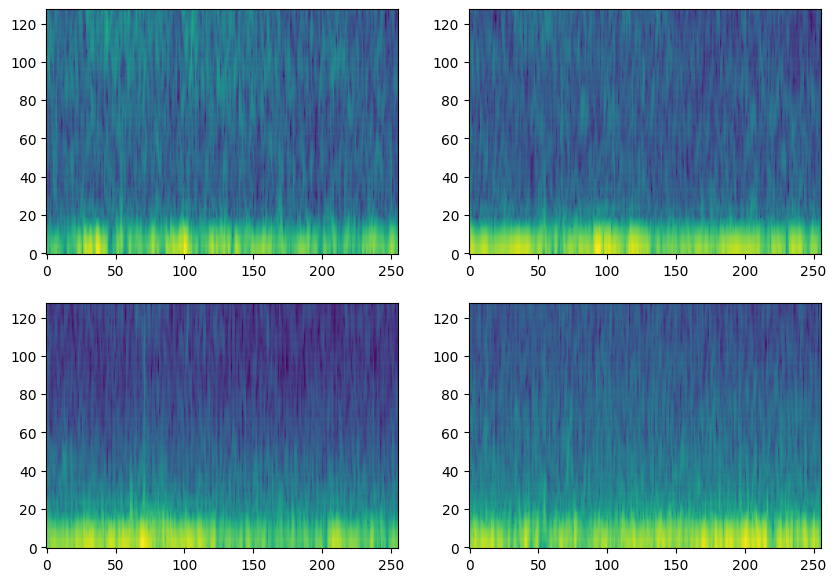

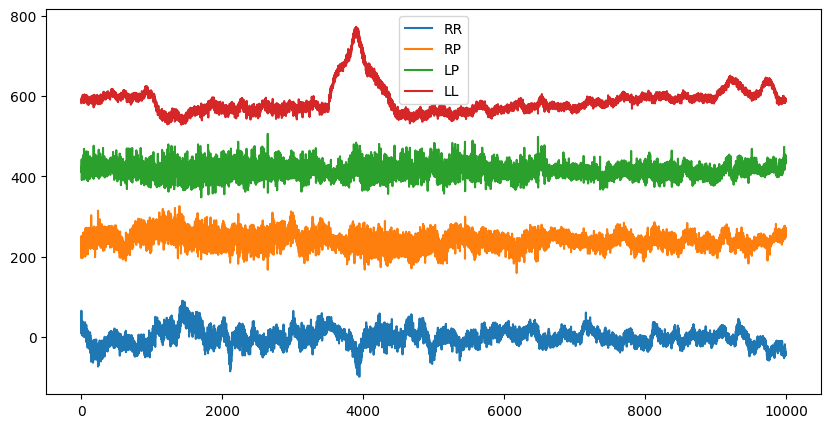


#########################



In [27]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

In [28]:
# INFER EFFICIENTNET ON TEST
preds = []
model = build_model()
test_gen = DataGenerator(test, spectrograms2, all_eegs2, shuffle=False, batch_size=64, mode='test')

for i in range(FOLDS):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM_2:
        model.load_weights(os.path.join(LOAD_MODELS_FROM_2, f'EffNet_pop2_v{VERSION}_f{i}.h5'))
    else:
        model.load_weights(os.path.join(MODEL_LOC, f'EffNet_pop2_v{VERSION}_f{i}.h5'))
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 4s 4s/step
Fold 2
1/1 [==============================] - 0s 46ms/step
Fold 3
1/1 [==============================] - 0s 45ms/step
Fold 4
1/1 [==============================] - 0s 42ms/step
Fold 5
1/1 [==============================] - 0s 45ms/step

Test preds shape (1, 6)


In [29]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.036011,0.056051,0.000674,0.516698,0.06236,0.328206


In [30]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32

In [31]:
!touch submission.csv